# REINFORCE Algorithm

## Load Basic Dependencies

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
from tqdm.notebook import trange

## The Environment

In [3]:
import gymnasium as gym

## Policy Network

In [4]:
def create_policy_network():
    return torch.nn.Sequential(
        torch.nn.Linear(4, 150),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(150, 2),
        torch.nn.Softmax(dim=0)
    )

In [5]:
def discount_rewards(rewards, discount_factor):
    ret = torch.pow(discount_factor, torch.arange(len(rewards)).float()) * rewards
    return ret / torch.max(ret)

In [6]:
def loss_fn(action_probs, disc_rewards):
    return -1 * torch.sum(disc_rewards * torch.log(action_probs))

In [7]:
def filter_timeseries(ts, p):
    tsf = np.nan * np.ones_like(ts)
    prev = ts[0]
    for i, v in enumerate(ts):
        tsf[i] = prev = p * prev + (1-p) * v
    return tsf

In [8]:
def compute_loss(model, loss_function, experience, gamma):
    states = torch.Tensor([s for (s, a, r) in experience])
    # states = torch.Tensor(np.vstack([s for (s, a, r) in experience]))
    actions = torch.Tensor([a for (s, a, r) in experience])
    rewards = np.array([r for (s, a, r) in experience])
    rewards = [np.sum(rewards[i:]) for i in range(len(rewards))]
    rewards = torch.Tensor(rewards)
    # ----
    rewards_disc = discount_rewards(rewards, gamma)
    predictions = model(states)
    probs = predictions.gather(dim=1, index=actions.long().view(-1, 1)).squeeze()
    return loss_function(probs, rewards_disc)

In [9]:
def choose_action(model, state):
    possible_actions = np.array([0, 1])
    probs = model(torch.from_numpy(state).float())
    return np.random.choice(possible_actions, p=probs.data.numpy())
    # return np.random.choice(range(len(probs)), p=probs.data.numpy())

In [10]:
def take_action(game, action):
    state, reward, terminated, truncated, _ = game.step(action)
    done = terminated or truncated
    return state, reward, done

## Training Loop

In [11]:
def train_agent(model, optimizer, gamma=0.99, max_duration=250, episodes=500):
    env = gym.make("CartPole-v1")
    possible_actions = np.array([0, 1])
    scores = []
    for episode_ndx in trange(episodes):
        s, _ = env.reset()
    
        episode = []
        for t in range(max_duration):
            a = choose_action(model, s)
            s_new, r, terminate = take_action(env, a)
            episode.append((s, a, r))
            s = s_new
            if terminate:
                break
    
        scores.append(len(episode))
        loss = compute_loss(model, loss_fn, episode, gamma=gamma)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return scores

In [12]:
MAX_DURATION = 250
EPISODES = 500
GAMMA = 0.99

In [13]:
MODEL = create_policy_network()

In [14]:
OPTIMIZER = torch.optim.Adam(MODEL.parameters(), lr=0.1)

In [15]:
SCORES = train_agent(MODEL, OPTIMIZER, gamma=GAMMA, max_duration=MAX_DURATION, episodes=EPISODES)

  0%|          | 0/500 [00:00<?, ?it/s]

/var/folders/kh/3m0ztz3940n1ryz6tm09zyd80000gn/T/ipykernel_21473/3942251252.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  states = torch.Tensor([s for (s, a, r) in experience])


In [16]:
def visualize_scores(scores):
    scores = np.array(scores)
    filtered = filter_timeseries(scores, 0.95)
    data = np.zeros((len(scores), 2))
    data[:,0] = scores
    data[:,1] = filtered
    plt.plot(data)

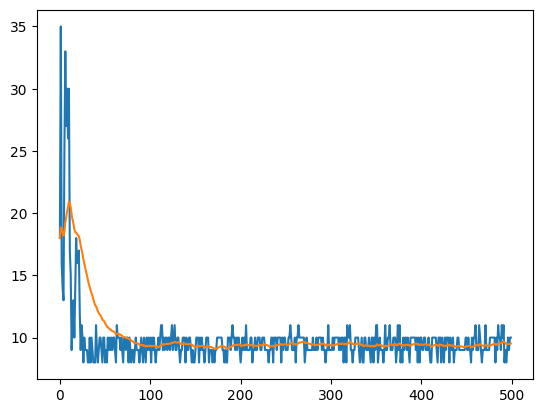

In [17]:
visualize_scores(SCORES)